<a href="https://colab.research.google.com/github/Faareh-Ahmed/Segment-Green-Spaces/blob/main/Evaluation_Metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Accuracy Metrics for SAM2 generated Masks

In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 70.0 MB/s eta 0:00:00


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import rasterio

def compute_iou(y_pred, y_true):
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    current = confusion_matrix(y_true, y_pred, labels=[0, 1])
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

def compute_dice(y_pred, y_true):
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    current = confusion_matrix(y_true, y_pred, labels=[0, 1])
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    dice = (2 * intersection) / (ground_truth_set + predicted_set).astype(np.float32)
    return np.mean(dice)

def compute_pixel_accuracy(y_pred, y_true):
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    current = confusion_matrix(y_true, y_pred, labels=[0, 1])
    correct_pixels = np.diag(current).sum()
    total_pixels = current.sum()
    pixel_accuracy = correct_pixels / total_pixels
    return pixel_accuracy

# Load the images
with rasterio.open('/content/sample_data/segment_12NDVI_another.tif') as ndvi_file:
    ndvi_image = ndvi_file.read(1)  # Read the first band
    ndvi_image = (ndvi_image > 0.6).astype(np.uint8)

with rasterio.open('/content/sample_data/mask_12.tif') as sam_file:
    sam_mask = sam_file.read(1)  # Read the first band
    sam_mask=(sam_mask > 0).astype(np.uint8)

# Threshold NDVI to create binary ground truth (e.g., NDVI > 0.3 for vegetation)
# ndvi_binary = (ndvi_image > 0.3).astype(np.uint8)

# # Ensure the SAM mask is binary
# sam_binary = (sam_mask > 0).astype(np.uint8)

# Compute metrics
iou = compute_iou(sam_mask, ndvi_image)
dice = compute_dice(sam_mask, ndvi_image)
pixel_accuracy = compute_pixel_accuracy(sam_mask, ndvi_image)

# Print results
print(f"IoU: {iou:.4f}")
print(f"Dice Coefficient: {dice:.4f}")
print(f"Pixel Accuracy: {pixel_accuracy:.4f}")


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


RasterioIOError: Read failed. See previous exception for details.

NDVI image shape: (256, 256)
SAM mask shape: (256, 256)
Unique values in NDVI binary: [0 1]
Unique values in SAM binary: [0 1]
IoU: 0.6482
Dice Coefficient: 0.7817
Pixel Accuracy: 0.8089


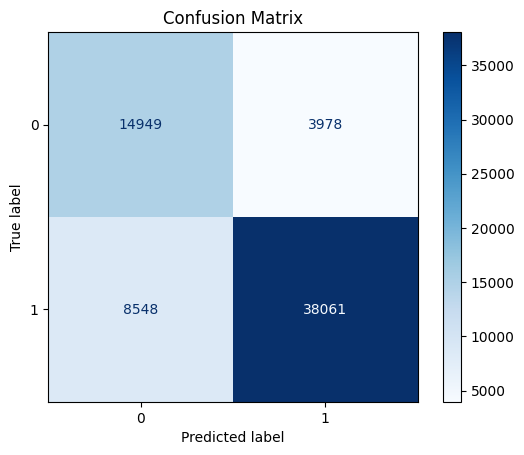

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import numpy as np
import rasterio

# Function to compute and visualize confusion matrix
def plot_confusion_matrix(y_pred, y_true):
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

# Compute difference between NDVI and SAM masks
def compute_difference(ndvi_image, sam_mask):
    return ndvi_image - sam_mask

# Load the images
with rasterio.open('/content/sample_data/segment_12NDVI_another.tif') as ndvi_file:
    ndvi_image = ndvi_file.read(1)  # Read the first band
    ndvi_image = (ndvi_image > 0.6).astype(np.uint8)

with rasterio.open('/content/sample_data/mask_12.tif') as sam_file:
    sam_mask = sam_file.read(1)  # Read the first band
    sam_mask=(sam_mask > 0).astype(np.uint8)

print("NDVI image shape:", ndvi_image.shape)
print("SAM mask shape:", sam_mask.shape)

print("Unique values in NDVI binary:", np.unique(ndvi_image))
print("Unique values in SAM binary:", np.unique(sam_mask))
# Threshold NDVI to create binary ground truth (e.g., NDVI > 0.3 for vegetation)
# ndvi_binary = (ndvi_image > 0.3).astype(np.uint8)

# # Ensure the SAM mask is binary
# sam_binary = (sam_mask > 0).astype(np.uint8)

# Compute metrics
iou = compute_iou(sam_mask, ndvi_image)
dice = compute_dice(sam_mask, ndvi_image)
pixel_accuracy = compute_pixel_accuracy(sam_mask, ndvi_image)

# Print results
print(f"IoU: {iou:.4f}")
print(f"Dice Coefficient: {dice:.4f}")
print(f"Pixel Accuracy: {pixel_accuracy:.4f}")

# Visualize confusion matrix
plot_confusion_matrix(sam_mask, ndvi_image)

# Compute the difference between NDVI and SAM masks
difference = compute_difference(ndvi_image, sam_mask)

# Plot the difference
# plt.figure(figsize=(8, 8))
# plt.imshow(difference, cmap='RdBu', interpolation='none')
# plt.colorbar(label='Difference (NDVI - SAM)')
# plt.title("Difference Between NDVI and SAM Masks")
# plt.show()


# For dealing with PNG output:

# Segment and Extract Green Spaces using OpenCV

NDVI mask shape:  (5287, 8192)
Unique values in NDVI binary:  [  0 255]


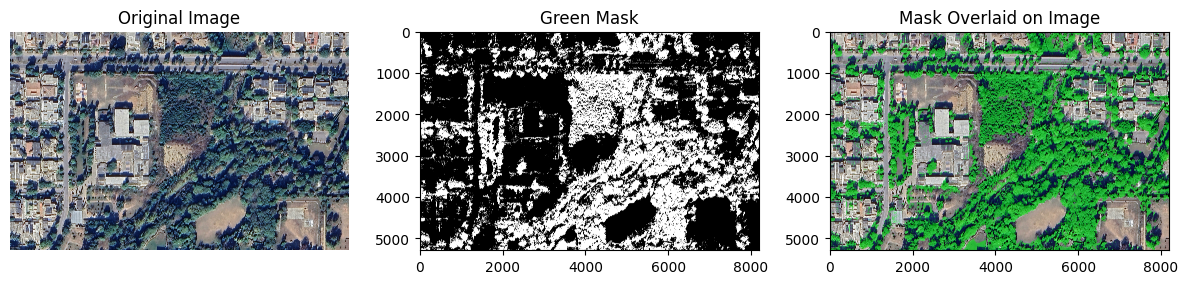

In [19]:
import cv2
from PIL import Image
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Normalize image to 0-255 range
def normalize_image(image_array):
    return ((image_array - image_array.min()) / (image_array.max() - image_array.min()) * 255).astype(np.uint8)

# Binarize the image with a threshold
def load_and_binarize_image(image_path, threshold=128):
    image = Image.open(image_path).convert("L")  # Load as grayscale
    image_array = np.array(image)
    normalized_image = normalize_image(image_array)  # Normalize first
    binary_image = (normalized_image > threshold).astype(np.uint8)
    return binary_image, image_array

# Extract green region from RGB image
def extract_green_region(image_path, lower_hsv=(35, 50, 50), upper_hsv=(85, 255, 255)):
    """
    Extracts the dark green regions (e.g., trees) from an image while avoiding shadows.

    Args:
        image_path (str): Path to the image.
        lower_hsv (tuple): Lower bound for HSV values (default: dark green).
        upper_hsv (tuple): Upper bound for HSV values (default: light green).

    Returns:
        np.ndarray: Binary mask of green regions (1 for green, 0 for others).
        np.ndarray: Original image as a NumPy array.
    """
    # Load image
    image = Image.open(image_path).convert("RGB")
    image_array = np.array(image)

    # Convert RGB to HSV
    hsv_image = cv2.cvtColor(image_array, cv2.COLOR_RGB2HSV)

    # Create a mask for the green color in the specified HSV range
    green_mask = cv2.inRange(hsv_image, np.array(lower_hsv), np.array(upper_hsv))

    # Optional: Remove small noise and smooth the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    green_mask = cv2.morphologyEx(green_mask, cv2.MORPH_CLOSE, kernel)
    green_mask = cv2.morphologyEx(green_mask, cv2.MORPH_OPEN, kernel)

    # Return the binary mask and the original image
    return green_mask.astype(np.uint8), image_array

def overlay_mask_on_image(original, mask, color=(255, 0, 0), alpha=0.5):
    """
    Overlays the binary mask on the original image with a given color and transparency.

    Args:
        original (np.ndarray): Original image as a NumPy array.
        mask (np.ndarray): Binary mask of green regions.
        color (tuple): RGB color for the mask overlay (default: red).
        alpha (float): Transparency of the mask (default: 0.5).

    Returns:
        np.ndarray: Image with the mask overlaid.
    """
    overlay = original.copy()
    overlay[mask > 0] = (
        (1 - alpha) * overlay[mask > 0] + alpha * np.array(color)
    ).astype(np.uint8)
    return overlay

# Colorize green regions
def colorize_green_regions(original_image, green_mask):
    colorized_image = original_image.copy()
    colorized_image[green_mask == 0] = [0, 255, 0]  # Set green regions to bright green
    return colorized_image

# Extract blue region from RGB image
def extract_blue_region(image_path, lower_bound=50, upper_bound=200):
    image = Image.open(image_path).convert("RGB")  # Load as RGB
    image_array = np.array(image)
    blue_mask = (image_array[..., 2] > lower_bound) & (image_array[..., 2] < upper_bound)
    return blue_mask.astype(np.uint8), image_array

# Colorize blue regions
def colorize_blue_regions(original_image, blue_mask):
    colorized_image = original_image.copy()
    colorized_image[blue_mask == 0] = [0, 0, 255]  # Set blue regions to bright blue
    return colorized_image


# Colorize the SAM masks
def colorize_SAM_mask(binary_mask, color=[0, 0, 255]):  # Default color: Red
    # Create an empty color image
    colorized_image = np.zeros((*binary_mask.shape, 3), dtype=np.uint8)
    # Apply color where the mask is 1
    colorized_image[binary_mask == 0] = color
    return colorized_image

# Resize or crop images to match dimensions
def resize_image(image, target_shape):
    return np.array(Image.fromarray(image).resize((target_shape[1], target_shape[0]), Image.NEAREST))

# Metrics
def compute_iou(y_pred, y_true):
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    current = confusion_matrix(y_true, y_pred, labels=[0, 1])
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

def compute_metrics(y_pred, y_true):
    """
    Compute Precision, Recall, and Accuracy for binary segmentation.

    Args:
        y_pred (numpy.ndarray): Predicted binary mask.
        y_true (numpy.ndarray): Ground truth binary mask.

    Returns:
        precision (float): Precision value.
        recall (float): Recall value.
        accuracy (float): Accuracy value.
    """
    # Flatten both arrays
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()

    # Confusion matrix components
    TP = np.sum((y_pred == 1) & (y_true == 1))  # True Positives
    TN = np.sum((y_pred == 0) & (y_true == 0))  # True Negatives
    FP = np.sum((y_pred == 1) & (y_true == 0))  # False Positives
    FN = np.sum((y_pred == 0) & (y_true == 1))  # False Negatives

    # Precision: TP / (TP + FP)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0

    # Recall: TP / (TP + FN)
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0

    # Accuracy: (TP + TN) / (TP + TN + FP + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    return precision, recall, accuracy

def compute_dice(y_pred, y_true):
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    current = confusion_matrix(y_true, y_pred, labels=[0, 1])
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    dice = (2 * intersection) / (ground_truth_set + predicted_set).astype(np.float32)
    return np.mean(dice)

def compute_pixel_accuracy(y_pred, y_true):
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    current = confusion_matrix(y_true, y_pred, labels=[0, 1])
    correct_pixels = np.diag(current).sum()
    total_pixels = current.sum()
    pixel_accuracy = correct_pixels / total_pixels
    return pixel_accuracy

def plot_confusion_matrix(y_pred, y_true):
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

# Paths to images
ndvi_path = "/content/sample_data/ISL_04_06.jpg"
ndvi_image, green_color_image = extract_green_region(
    ndvi_path,
    # Define initial HSV bounds for green regions
    lower_hsv = (30, 30, 30),  # Darker green
    upper_hsv = (110, 255, 255)  # Lighter green
)

print("NDVI mask shape: ", ndvi_image.shape)
print("Unique values in NDVI binary: ", np.unique(ndvi_image))


# Create an overlay image
overlay_image = overlay_mask_on_image(green_color_image, ndvi_image, color=(0, 255, 0), alpha=0.5)

# Save or visualize the mask if needed
Image.fromarray(ndvi_image).save("green_mask.jpg")
Image.fromarray(overlay_image).save("mask_overlay.jpg")




# Visualize images and differences
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(green_color_image)
plt.title("Original Image")
plt.axis("off")

# Masked Image
plt.subplot(1, 3, 2)
plt.imshow(ndvi_image, cmap="gray")
plt.title("Green Mask")
plt.axis("on")

# Overlayed Image
plt.subplot(1, 3, 3)
plt.imshow(overlay_image)
plt.title("Mask Overlaid on Image")
plt.axis("on")

plt.tight_layout()
plt.show()



## Fill the Small Pores

In [20]:
import cv2
import numpy as np
from PIL import Image

def fill_white_regions(mask):
    """
    Fills small black holes in white regions of a binary mask.

    Args:
        mask (np.ndarray): Binary mask where 1 is white and 0 is black.

    Returns:
        np.ndarray: Processed mask with continuous white regions.
    """
    # Convert to OpenCV format (0-255 range)
    mask = (mask * 255).astype(np.uint8)

    # Find contours to isolate white regions
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask for the filled regions
    filled_mask = np.zeros_like(mask, dtype=np.uint8)

    # Iterate through the contours and fill the enclosed areas
    for cnt in contours:
        # Check if the contour is large enough (to avoid filling very small noise)
        if cv2.contourArea(cnt) > 100:  # Adjust this threshold as needed
            cv2.drawContours(filled_mask, [cnt], -1, 255, thickness=cv2.FILLED)

    return filled_mask

# Load the binary mask image (grayscale)
mask_image = cv2.imread("green_mask.jpg", cv2.IMREAD_GRAYSCALE)

# Threshold to ensure binary format (1 for white, 0 for black)
_, mask_binary = cv2.threshold(mask_image, 128, 1, cv2.THRESH_BINARY)  # Correct thresholding

# Apply the post-processing function
processed_mask = fill_white_regions(mask_binary)

# Save the processed mask
Image.fromarray(processed_mask).save("processed_green_mask.jpg")

# extracting points

Green Points: [(3143, 4774), (6619, 4239), (7050, 3295), (6027, 5176), (1007, 2218), (4474, 5193), (2223, 5024), (2275, 5026), (1181, 467), (2846, 2678)]
Non-Green Points: [(2799, 3242), (3103, 354), (7579, 5202), (2118, 1347), (5231, 725), (8112, 1060), (1877, 3662), (196, 4513), (2481, 52), (1097, 636)]


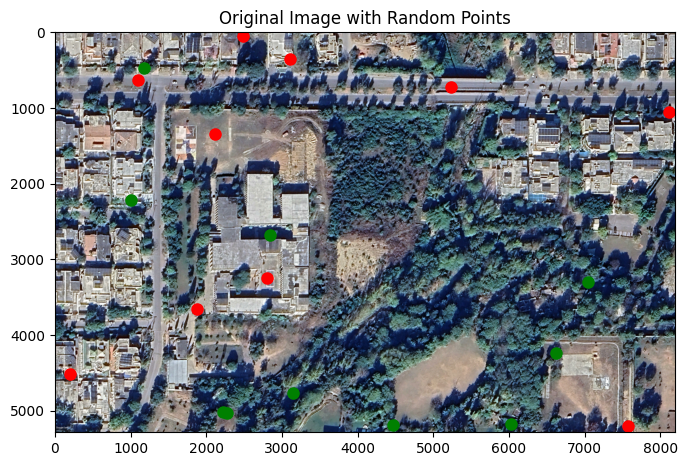

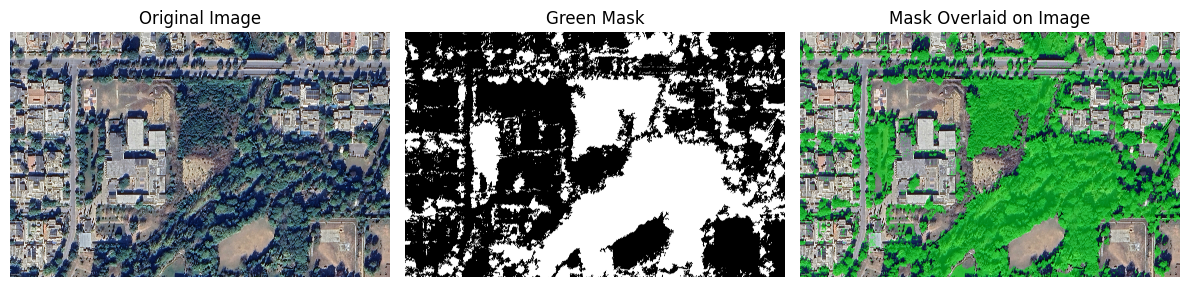

In [21]:
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Normalize image to 0-255 range
def normalize_image(image_array):
    return ((image_array - image_array.min()) / (image_array.max() - image_array.min()) * 255).astype(np.uint8)

# Extract green region from RGB image
def extract_green_region(image_path, lower_hsv=(35, 50, 50), upper_hsv=(85, 255, 255)):
    """
    Extracts the dark green regions (e.g., trees) from an image while avoiding shadows.
    """
    # Load image
    image = Image.open(image_path).convert("RGB")
    image_array = np.array(image)

    # Convert RGB to HSV
    hsv_image = cv2.cvtColor(image_array, cv2.COLOR_RGB2HSV)

    # Create a mask for the green color in the specified HSV range
    green_mask = cv2.inRange(hsv_image, np.array(lower_hsv), np.array(upper_hsv))

    # Remove small noise and smooth the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    green_mask = cv2.morphologyEx(green_mask, cv2.MORPH_CLOSE, kernel)
    green_mask = cv2.morphologyEx(green_mask, cv2.MORPH_OPEN, kernel)

    return green_mask.astype(np.uint8), image_array

# Overlay mask on image
def overlay_mask_on_image(original, mask, color=(255, 0, 0), alpha=0.5):
    """
    Overlays the binary mask on the original image with a given color and transparency.
    """
    overlay = original.copy()
    overlay[mask > 0] = (
        (1 - alpha) * overlay[mask > 0] + alpha * np.array(color)
    ).astype(np.uint8)
    return overlay

# Pick random points from a given mask
def pick_random_points(mask, num_points=5, condition=True):
    """
    Picks random points based on a condition (green area or non-green area).
    """
    coords = np.argwhere(mask > 0) if condition else np.argwhere(mask == 0)

    if len(coords) < num_points:
        raise ValueError("Not enough points in the mask to pick from.")

    selected_points = coords[np.random.choice(len(coords), num_points, replace=False)]
    return [(x, y) for y, x in selected_points]  # Convert (row, col) to (x, y)

# Paths to images
original_image_path = "/content/sample_data/ISL_04_06.jpg"
green_mask_path = "/content/processed_green_mask.jpg"

# Load original image correctly
original_image = cv2.imread(original_image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct visualization

# Load green mask correctly
green_mask = cv2.imread(green_mask_path, cv2.IMREAD_GRAYSCALE)

# Pick random points from green and non-green areas
green_points = pick_random_points(green_mask, num_points=10, condition=True)
non_green_points = pick_random_points(green_mask, num_points=10, condition=False)

print("Green Points:", green_points)
print("Non-Green Points:", non_green_points)

# Plot the original image with the selected points
plt.figure(figsize=(8, 8))
plt.imshow(original_image)
plt.title("Original Image with Random Points")
plt.axis("on")

# Mark the random points on the image
for (x, y) in green_points:
    plt.plot(x, y, 'go', markersize=8, label="Green Area")  # Green dots for green points

for (x, y) in non_green_points:
    plt.plot(x, y, 'ro', markersize=8, label="Non-Green Area")  # Red dots for non-green points

# Create the overlay image
overlay_image = overlay_mask_on_image(original_image, green_mask, color=(0, 255, 0), alpha=0.5)

# Visualize images
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(green_mask, cmap="gray")
plt.title("Green Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlay_image)
plt.title("Mask Overlaid on Image")
plt.axis("off")

plt.tight_layout()
plt.show()


# Camparing the Green Mask with Original Image to get Binary Image Mask of Green Space

ndvi mask shape: (3790, 8192)
Unique values in ndvi binary: [  0 255]


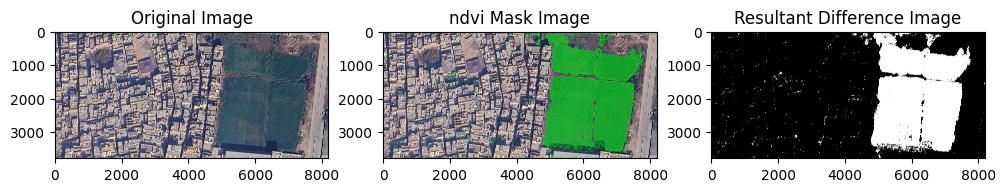

Resultant difference image saved to: NDVI_difference_result.png


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load images
original_image_path = '/content/sample_data/110.jpg'  # Path to raw image
ndvi_mask_image_path = '/content/mask_overlay.jpg'  # Path to SAM mask image

# Load the images using PIL
original_image = Image.open(original_image_path).convert("RGB")  # Convert to RGB
ndvi_mask_image = Image.open(ndvi_mask_image_path).convert("RGB")  # Convert to RGB

# Convert to numpy arrays for processing
original_image_array = np.array(original_image)
ndvi_mask_image_array = np.array(ndvi_mask_image)

# Convert both images to grayscale (single channel)
original_gray = original_image.convert("L")  # Convert to grayscale
ndvi_mask_gray = ndvi_mask_image.convert("L")  # Convert to grayscale

# Convert grayscale images to numpy arrays
original_gray_array = np.array(original_gray)
ndvi_mask_gray_array = np.array(ndvi_mask_gray)

# Ensure both images have the ndvie shape (resize if necessary)
if original_gray_array.shape != ndvi_mask_gray_array.shape:
    print("Correcting the Shape")
    ndvi_mask_gray_array = np.array(Image.fromarray(ndvi_mask_gray_array).resize((original_gray_array.shape[1], original_gray_array.shape[0]), Image.NEAREST))

# Compute the absolute difference between the two grayscale images
difference_image = np.abs(original_gray_array.astype(np.int16) - ndvi_mask_gray_array.astype(np.int16))

# Threshold the difference to emphasize the extracted mask (e.g., a simple threshold of 50)
threshold = 10
ndvi_mask_difference = (difference_image > threshold).astype(np.uint8) * 255  # Convert to black and white

print("ndvi mask shape:", ndvi_mask_difference.shape)
print("Unique values in ndvi binary:", np.unique(ndvi_mask_difference))

# Convert back to an image format
result_image = Image.fromarray(ndvi_mask_difference)

# Save the resultant image (optional)
result_image_path = 'NDVI_difference_result.png'
result_image.save(result_image_path)

# Display the images
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(ndvi_mask_image)
plt.title("ndvi Mask Image")

plt.subplot(1, 3, 3)
plt.imshow(ndvi_mask_difference, cmap='gray')
plt.title("Resultant Difference Image")

plt.show()

print(f"Resultant difference image saved to: {result_image_path}")


# SAM mask

SAM mask shape: (3793, 8200)
Original mask shape: (3790, 8192)
Correcting the Shape
SAM mask shape: (3790, 8192)
Unique values in SAM binary: [  0 255]


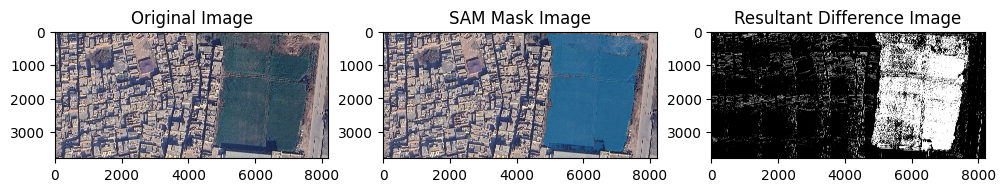

Resultant difference image saved to: SAM_difference_result.png


In [ ]:
import numpy as np
from PIL import Image, ImageFile
import matplotlib.pyplot as plt

# Load images
original_image_path = '/content/sample_data/110.jpg'  # Path to raw image
sam_mask_image_path = '/content/sample_data/110_Mask_heira_base_plus.png'  # Path to SAM mask image

# Handle truncated image files
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Load images
try:
    original_image = Image.open(original_image_path).convert("RGB")
    sam_mask_image = Image.open(sam_mask_image_path).convert("RGB")
except OSError as e:
    print(f"Error loading images: {e}")
    raise

# Convert to numpy arrays for processing
original_image_array = np.array(original_image)
sam_mask_image_array = np.array(sam_mask_image)

# Convert both images to grayscale (single channel)
original_gray = original_image.convert("L")  # Convert to grayscale
sam_mask_gray = sam_mask_image.convert("L")  # Convert to grayscale

# Convert grayscale images to numpy arrays
original_gray_array = np.array(original_gray)
sam_mask_gray_array = np.array(sam_mask_gray)

print("SAM mask shape:", sam_mask_gray_array.shape)
print("Original mask shape:", original_gray_array.shape)


# Ensure both images have the same shape (resize if necessary)
if original_gray_array.shape != sam_mask_gray_array.shape:
    print("Correcting the Shape")
    sam_mask_gray_array = np.array(Image.fromarray(sam_mask_gray_array).resize((original_gray_array.shape[1], original_gray_array.shape[0]), Image.NEAREST))

# Compute the absolute difference between the two grayscale images
difference_image = np.abs(original_gray_array.astype(np.int8) - sam_mask_gray_array.astype(np.int8))

# Threshold the difference to emphasize the extracted mask (e.g., a simple threshold of 50)
threshold = 8
SAM_mask_difference = (difference_image > threshold).astype(np.uint8) * 255  # Convert to black and white

# SAM_mask_difference=difference_image
print("SAM mask shape:", SAM_mask_difference.shape)
print("Unique values in SAM binary:", np.unique(SAM_mask_difference))

# Convert back to an image format
result_image = Image.fromarray(SAM_mask_difference).convert("L")  # Ensure grayscale (L mode)

# Save the resultant image (optional)
result_image_path = 'SAM_difference_result.png'
result_image.save(result_image_path)

# Display the images
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(sam_mask_image)
plt.title("SAM Mask Image")

plt.subplot(1, 3, 3)
plt.imshow(SAM_mask_difference, cmap='gray')
plt.title("Resultant Difference Image")

plt.show()

print(f"Resultant difference image saved to: {result_image_path}")


# Compute Evaluation

Unique values in new ndvi binary mask: [  0 255]
NDVI image shape: (3790, 8192)
Unique values in NDVI binary: [  0 255]
SAM mask shape (after resize and binarization): (3790, 8192, 3)
Unique values in SAM mask binary: [  0 255]
NDVI image shape: (3790, 8192)
Unique values in NDVI binary: [  0 255]
SAM mask shape (after resize and binarization): (3790, 8192)
Unique values in SAM mask binary: [  0 255]
Count of 0 values in NDVI: 18739229
Count of 255 values in NDVI: 12308451
Count of 0 values in SAM: 18931480
Count of 255 values in SAM: 12116200
Unique values in normalized SAM mask: [0 1]
Unique values in normalized NDVI mask: [0 1]
Count of 0 values in NDVI: 18739229
Count of 1 values in NDVI: 12308451
Count of 0 values in sam: 18931480
Count of 1 values in sam: 12116200
Precision: 0.8967
Recall: 0.8827
Accuracy: 0.9132
IoU: 0.8338
Dice Coefficient: 0.9090
Pixel Accuracy: 0.9132


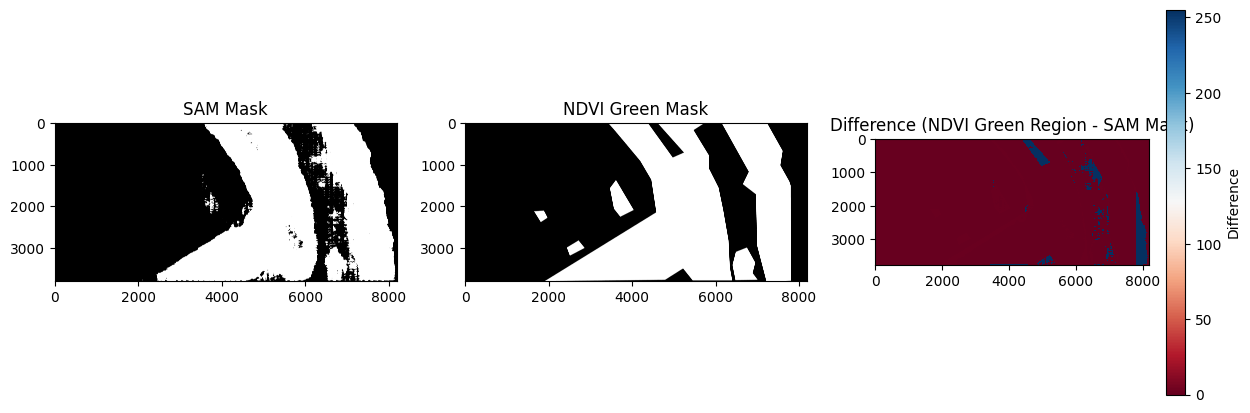

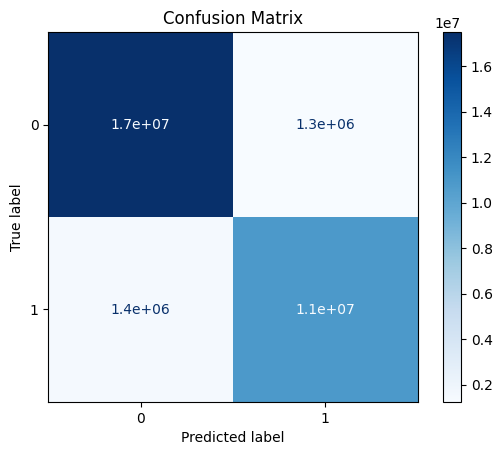

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load SAM mask image (original image with colorized SAM mask)
sam_mask_image_path = '/content/sample_data/107Mask.png'  # Path to SAM mask image
ndvi_image_path = '/content/sample_data/107GroundTruth.jpg'  # Path to NDVI image

# Load the images using PIL
sam_mask_image = Image.open(sam_mask_image_path).convert("RGB")  # Convert to RGB
ndvi_image = Image.open(ndvi_image_path).convert("L")  # Convert to grayscale for NDVI

# Convert to numpy arrays for processing
sam_mask_image_array = np.array(sam_mask_image)
ndvi_image_array = np.array(ndvi_image)

# Ensure the array has the correct data type
# ************************************************
#  FOR OUTSIDE GROUND TRUTH MASKS
if ndvi_image_array.dtype != np.uint8:
    ndvi_image_array = ndvi_image_array.astype(np.uint8)

# Define a threshold value (1 is correct for binary mapping)
threshold = 1

# Apply thresholding to binarize the array (0 or 255)
ndvi_image_array = np.where(ndvi_image_array > threshold, 255, 0).astype(np.uint8)

# Save the binary mask as an image
binary_mask_image = Image.fromarray(ndvi_image_array)
binary_mask_image.save('/content/sample_data/107GroundTruth_binary.jpg')

# Check the unique values in the processed mask
print("Unique values in new ndvi binary mask:", np.unique(ndvi_image_array))
# ************************************************


print("NDVI image shape:", ndvi_image_array.shape)
print("Unique values in NDVI binary:", np.unique(ndvi_image_array))
print("SAM mask shape (after resize and binarization):", sam_mask_image_array.shape)
print("Unique values in SAM mask binary:", np.unique(sam_mask_image_array))

# Resize SAM mask to match the shape of NDVI image
if sam_mask_image_array.shape[:2] != ndvi_image_array.shape:
    print("Correcting the Shape")
    sam_mask_image_resized = np.array(Image.fromarray(sam_mask_image_array).resize((ndvi_image_array.shape[1], ndvi_image_array.shape[0]), Image.NEAREST))
else:
    sam_mask_image_resized = sam_mask_image_array

# Convert the SAM mask image to grayscale (using the green channel as an example)
# You can modify this to use another channel (e.g., blue or red) based on your mask's characteristics
sam_mask_gray = sam_mask_image_resized[..., 1]  # Extract green channel (for example)

# Binarize the SAM mask (e.g., consider pixels above a certain threshold as mask pixels)
# threshold = 100  # You can adjust this threshold based on your needs
# sam_mask_binary = (sam_mask_gray > threshold).astype(np.uint8) * 255  # Convert to binary (0 and 255)

# Print shapes and unique values for verification
print("NDVI image shape:", ndvi_image_array.shape)
print("Unique values in NDVI binary:", np.unique(ndvi_image_array))
print("SAM mask shape (after resize and binarization):", sam_mask_gray.shape)
print("Unique values in SAM mask binary:", np.unique(sam_mask_gray))

# Count the number of 0 and 255 values in NDVI binary array
count_0_ndvi = np.sum(ndvi_image_array == 0)
count_255_ndvi = np.sum(ndvi_image_array == 255)

# Print the counts
print("Count of 0 values in NDVI:", count_0_ndvi)
print("Count of 255 values in NDVI:", count_255_ndvi)


# Count the number of 0 and 255 values in NDVI binary array
count_0_sam = np.sum(sam_mask_gray == 0)
count_255_sam = np.sum(sam_mask_gray == 255)

# Print the counts
print("Count of 0 values in SAM:", count_0_sam)
print("Count of 255 values in SAM:", count_255_sam)

# Normalize binary masks to have values 0 and 1
sam_mask_binary_normalized = (sam_mask_gray // 255).astype(np.uint8)
ndvi_image_binary_normalized = (ndvi_image_array // 255).astype(np.uint8)

# Print shapes and unique values for verification
print("Unique values in normalized SAM mask:", np.unique(sam_mask_binary_normalized))
print("Unique values in normalized NDVI mask:", np.unique(ndvi_image_binary_normalized))


# Count the number of 0 and 255 values in NDVI binary array
count_0_ndvi = np.sum(ndvi_image_binary_normalized == 0)
count_1_ndvi = np.sum(ndvi_image_binary_normalized == 1)

# Print the counts
print("Count of 0 values in NDVI:", count_0_ndvi)
print("Count of 1 values in NDVI:", count_1_ndvi)


# Count the number of 0 and 255 values in NDVI binary array
count_0_sam = np.sum(sam_mask_binary_normalized == 0)
count_1_sam = np.sum(sam_mask_binary_normalized == 1)

# Print the counts
print("Count of 0 values in sam:", count_0_sam)
print("Count of 1 values in sam:", count_1_sam)


# Compute metrics (IoU, Dice, pixel accuracy)
iou = compute_iou(sam_mask_binary_normalized, ndvi_image_binary_normalized)
dice = compute_dice(sam_mask_binary_normalized, ndvi_image_binary_normalized)
pixel_accuracy = compute_pixel_accuracy(sam_mask_binary_normalized, ndvi_image_binary_normalized)
# Compute Precision, Recall, and Accuracy
precision, recall, accuracy = compute_metrics(sam_mask_binary_normalized, ndvi_image_binary_normalized)

# Print the metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
# Print results
print(f"IoU: {iou:.4f}")
print(f"Dice Coefficient: {dice:.4f}")
print(f"Pixel Accuracy: {pixel_accuracy:.4f}")

# Visualize images and differences
plt.figure(figsize=(15, 5))

# Plot the SAM Mask
plt.subplot(1, 3, 1)
plt.title("SAM Mask")
plt.imshow(sam_mask_gray, cmap='gray')

# Plot the NDVI Green Mask (you can use `colorized_image` for visualization)
plt.subplot(1, 3, 2)
plt.title("NDVI Green Mask")
plt.imshow(ndvi_image_binary_normalized, cmap='gray')

# Plot the difference
plt.subplot(1, 3, 3)
difference = ndvi_image_binary_normalized - sam_mask_binary_normalized
plt.title("Difference (NDVI Green Region - SAM Mask)")
plt.imshow(difference, cmap='RdBu', interpolation='none')
plt.colorbar(label='Difference')
plt.show()

# Confusion matrix
plot_confusion_matrix(sam_mask_binary_normalized, ndvi_image_binary_normalized)
